#Deep-Q-Learning
Richard Acs - Z23536011 - 10/31/23 - Dr. Zhong

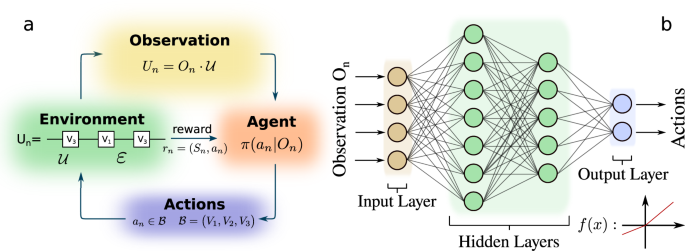

This assignment focuses on expanding the Q-learning grid world example seen in project 1 to involve deep Q-learning. Although Q-learning with Q-tables is a powerful and useful methodology in reinforcement learning, it becomes computationally infeasible as the number of states increases due to the increased size and complexity of the required Q-table. Thus, deep Q-learning aims to replace the Q-Table with a neural network that is trained to output the Q-value action pairs for each state, which is what we explore in this project in order to guide the agent using the optimal path to the goal node.  



---



##Classes and Supporting Functions Setup

This section prepares the two main classes used to create the Q-learning maze. The agent class contains attributes which keep track of the current position of the Q-learning algorithm in the maze and supporting functions to update its position based on a given actions and keep a running path history. The grid world class serves to contain the maze environment that the agent will interact with. This class holds the maze layout, rewards for each state, functions to check the current state types (goal, obstacle, or none) based on a given coordinate, and a function to graphically print out the maze with the corresponding agent path. Since this project uses deep Q-learning to replace the Q-table, no Q-table class is needed.

In [ ]:
##Dependencies
import matplotlib as mlib
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow import keras
from collections import deque
import time

###**Map Layout**

The cell below contains the map layout with corresponding reward values. An obstacle or boundary is represented by -10, a non-zero positive number is a goal state with the associated reward, and all other spaces are 0.



In [ ]:
##Game and reward map can be changed to modify the agent's environment and rewards

reward_map = np.array([
    [-10, -10,  -10,  -10,  -10],
    [-10,   0,    0,    0,  -10],
    [-10,   0,  -10,    0,  -10],
    [-10,   0,  -10,  -10,  -10],
    [-10,   0,    0,    0,  -10],
    [-10,   0,    0,  100,  -10],
    [-10, -10,  -10,  -10,  -10]
])

###**Gridworld Class**

This class contains the environment map, functions to get the reward corresponding to the current agent position, check the current state based on the agent's position, and to graphically plot the map and path of the agent.


In [ ]:
class gridworld():

  def __init__(self, map):
    self.map = map

  ##Function to get the reward value given the position and next action
  def getReward(self, currPos, action):
    X = currPos[0]
    Y = currPos[1]
    if (action == 'left'):
      is_goal = self.checkState([X-1, Y])
      if is_goal == 1:
        is_goal = True
      else:
        is_goal = False
      return(self.map[Y][X-1], [X-1, Y], is_goal)
    if (action == 'right'):
      is_goal = self.checkState([X+1, Y])
      if is_goal == 1:
        is_goal = True
      else:
        is_goal = False
      return(self.map[Y][X+1], [X+1, Y], is_goal)
    if (action == 'up'):
      is_goal = self.checkState([X, Y+1])
      if is_goal == 1:
        is_goal = True
      else:
        is_goal = False
      return(self.map[Y+1][X], [X, Y+1], is_goal)
    if (action == 'down'):
      is_goal = self.checkState([X, Y-1])
      if is_goal == 1:
        is_goal = True
      else:
        is_goal = False
      return(self.map[Y-1][X], [X, Y-1], is_goal)

  ##Function to check the state value given the current position
  def checkState(self, currPos):
    X = currPos[0]
    Y = currPos[1]
    if self.map[Y][X] > 0:
      return(1)
    elif self.map[Y][X] < 0:
      return(-1)
    elif self.map[Y][X] == 0:
      return(0)

  ##Function to plot the environment and trace a path of moves
  def plot(self, moveList=[]):
    colors=['black', 'white', 'black', 'green']
    bounds=[-11, -1, 1, 1.5, 1000]
    cmap = mlib.colors.ListedColormap(colors)
    norm = mlib.colors.BoundaryNorm(bounds, cmap.N)

    plt.grid(axis='both', color='k', linewidth=2)
    plt.xticks(np.arange(0.5, self.map.shape[1], 1))
    plt.yticks(np.arange(0.5, self.map.shape[0], 1))

    plt.tick_params(bottom=False, top=False, left=False,
                    right=False, labelbottom=False, labelleft=False)
    xpoints = []
    ypoints = []
    for i in moveList:
      xpoints.append(i[0])
      ypoints.append(i[1])

    for i in range (0, len(self.map)):
      for j in range (0, len(self.map[0])):
        if self.map[i][j] > 0:
          plt.text(j,i,self.map[i][j],  ha='center', va='center')

    plt.plot(np.array(xpoints), np.array(ypoints))
    plt.imshow(self.map, cmap=cmap, norm=norm)

###**Agent Class**

This class contains attributes to store the current position of the agent, a history of previous agent positions, a function to update the position and move history based on an action, and a function to reset the agent's position and move list.

In [ ]:
class agent():

  def __init__(self, position = [1,1]):
    self.currPos = position
    self.moveList = []

  ##Function to update the position and move history of agent given an action
  def move(self, action):
      oldX = self.currPos[0]
      oldY = self.currPos[1]
      if action == 'left':
        self.currPos = [oldX - 1, oldY]
        self.moveList.append([oldX, oldY])
      elif action == 'right':
        self.currPos = [oldX + 1, oldY]
        self.moveList.append([oldX, oldY])
      elif action == 'up':
        self.currPos = [oldX, oldY + 1]
        self.moveList.append([oldX, oldY])
      elif action == 'down':
        self.currPos = [oldX, oldY - 1]
        self.moveList.append([oldX, oldY])

  ##Function to reset the agent to the start
  def reset(self):
    self.currPos = [1,1]
    self.moveList.clear()

##**Deep Q-Learning Functions**


This class contains the functions that define the neural network architecture, the training process, and the main deep Q-learning function which serves as a driver for the training process. The agent_model function defines the model architecture, which is created using Keras and is used to create both the main model and the target model. The train function is used to train the main model using replay memory and the bellman equation to calculate TD error when fitting the weights of the model. Finally, the main driver main_deep_QL function is used to configure epsilon greedy learning, the number of batches, create the deque for replay memory and append different (state, action, reward, newstate) instances to the deque by making predictions on the main model, update the target model, and print the total reward each episode to show the converging process.

Overall, these functions help to create a deep Q-learning environment which essentially consists of:

*   A main neural network to get the q value for each action given a current state. This neural network is trained using replay memory, and it is first trained after creating an initial bank of 1000 (state, action, reward, newstate) instances, and trained there after once every 4 additional instances are added to the bank. The network is trained by splitting the entire replay memory into mini-batches each time it trains, and then making predictions on the maximum Q-value of the next state using a target network in order to train the model weights using temporal difference.

*   A target neural network, identical to the first neural network but it serves as a lagging copy of the main neural network and only copies over the weights from the main neural network every 100 steps of the agent. This network is used to predict the next states max Q-value, which is used as the 'Y' label when fitting the function, emulating temporal difference.

*   Auxiliary functions and loops to control how many episodes the function runs for, when to copy over the weights from the main to the target network, epsilon greedy start, end, and decay rates, batch sizes, learning rates, and other hyperparameters.



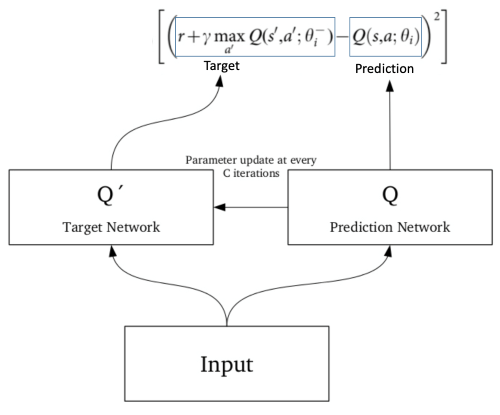

###**Model Architecture Function**

This function creates the model architecture for both the main and target networks using one input layer, two hidden layers, and a final output layer which has four output nodes, one for each action and associated Q-value.

In [ ]:
#Main model architecture:
#1 input layer of size 2 (x and y coorditate)
#2 hidden layers of size 24 and 12 respectively
#1 output layer of size 4 (4 actions)
def agent_model():
  learning_rate = 0.001
  init = tf.keras.initializers.HeUniform()
  model = keras.Sequential()
  model.add(keras.layers.Dense(24, input_shape=(2,), activation='relu', kernel_initializer=init))
  model.add(keras.layers.Dense(12, activation='relu', kernel_initializer=init))
  model.add(keras.layers.Dense(4, activation='linear', kernel_initializer=init))
  model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(lr=learning_rate), metrics=['accuracy'])
  return model


###**Training Function**

This function trains the main network using replay memory. It takes the deque of replay memory instances, and once the deck is greater than 1000 instances, it uses the target network to predict the next state's maximum Q-value. It then uses those predicted values as the labels against which compare the main model's predicted q value (emulating temporal difference), and then trains the network weights using those two values. Finally, training is done in mini batches, and the learning rate, discount factor, and batch size are all tunable hyperparameters that impact the convergence time.

In [ ]:
#Main training loop function
def model_train(map, replay_memory, model, target_model, loss_curve, model_weights, iteration, learning_rate, discount_factor):

  #Define layer sizes
  l1 = 2
  l2 = 24
  l3 = 12
  l4 = 4

  #Only train if replay memory deque is greater than 1000 instances
  if len(replay_memory) < 1000:
    return

  #Create batch for training and target network prediction
  batch_len = 128
  batch = random.sample(replay_memory, batch_len)
  curr_states = np.array([temp[0] for temp in batch])
  current_qs_list = model.predict(curr_states, verbose=0)
  new_curr_states = np.array([temp[3] for temp in batch])
  future_qs_list = target_model.predict(new_curr_states, verbose=0)

  #Use bellman equation to calculate updated Q value for main NN training
  X = []
  Y = []
  for index, (curr_state, action, reward, new_state, done) in enumerate(batch):
    if not done:
      max_future_q = reward + discount_factor * np.max(future_qs_list[index])
    else:
      max_future_q = reward

    X.append(curr_state)
    current_qs = current_qs_list[index]
    current_qs[action] = (1 - learning_rate) * current_qs[action] + learning_rate * max_future_q
    Y.append(current_qs)

  #Train the model using current state and the current_qs from bellman update
  loss = model.fit(np.array(X), np.array(Y), batch_size=batch_len, verbose=0, shuffle=True)
  loss_curve.append(loss.history['loss'])

  #Save weights for graphing
  if iteration % 50 == 0:
    weight_number = 0
    first_layer_weights = model.layers[0].get_weights()[0]
    second_layer_weights = model.layers[1].get_weights()[0]
    third_layer_weights = model.layers[2].get_weights()[0]
    for i in range(l1):
      for j in range(l2):
        model_weights[weight_number].append(first_layer_weights[i][j])
        weight_number = weight_number+1
    for i in range(l2):
      for j in range(l3):
        model_weights[weight_number].append(second_layer_weights[i][j])
        weight_number = weight_number+1
    for i in range(l3):
      for j in range(l4):
        model_weights[weight_number].append(third_layer_weights[i][j])
        weight_number = weight_number+1


###**Main Deep Q Learning Function**

This function serves as the driver for the Deep-Q Learning process. The main episode control loop, epsilon greedy decay method, action selection, replay memory setup, agent moving, and target network weight updates are all done within this function. This function also calls the train function only after creating 4 new entries into the replay memory (after the initial 1000), and it copies over the main network weights to the target network every 100 agent steps. To prevent the agent from getting stuck, this function also spikes the epsilon to 100% (actions completely random) if the agent takes too many steps and has not yet reached the goal. This function takes epsilon, max and min epsilon, the decay rate, and the number of training episodes as tunable parameters. Additionally, the function requires an agent and environment object, a list of possible actions, and the model and target model as input.

In [ ]:
#Main deep Q learning driver
def main_deep_QL(epsilon, max_epsilon, min_epsilon, decay, train_episodes, player, map, actionsList, model, target_model):

  #Setup replay memory, counter, and arrays
  replay_memory = deque(maxlen=50_000)
  target_update_counter = 0
  steps_to_update_target_model = 0
  loss_curve = []
  total_training = []
  model_weights = []
  for i in range((2*24 + 24*12 + 12*4)):
    model_weights.append([])

  #Main loop for each episode
  for episode in range(train_episodes):
    total_training_rewards = 0
    player.reset()
    curr_state = np.array(player.currPos)
    done = False
    steps_in_episode = 0

    #While the agent has not reached the goal
    while done != True:
        steps_to_update_target_model += 1
        steps_in_episode = steps_in_episode + 1
        if steps_in_episode == 150:
          epsilon = 1

        #Get best predicted action or epsilon greedy action
        random_number = np.random.rand()
        if random_number <= epsilon:
          action = random.randint(0, 3)
        else:
          encoded = curr_state
          predicted = model.predict(encoded.reshape([1, encoded.shape[0]]), verbose=0).flatten()
          action = np.argmax(predicted)

        #Get the reward and associated new state after doing the action
        reward, new_state, done = map.getReward(curr_state, actionsList[action])
        new_state = np.array(new_state)

        #Move agent to the next state
        if map.checkState(new_state) >=0:
          player.move(actionsList[action])
        else:
          new_state = curr_state

        #Store current instance into the replay memory
        replay_memory.append([curr_state, action, reward, new_state, done])

        #Train model using the replay memory bank every 4 iterations
        if steps_to_update_target_model % 4 == 0 or done:
          model_train(map, replay_memory, model, target_model, loss_curve, model_weights, steps_to_update_target_model, 0.7, 0.9)

        #Update current state and total training rewards
        curr_state = new_state
        total_training_rewards += reward

        #Print statements at the end of the episode
        if done:
          if episode % 10 == 0:
            print('Total training rewards: {} after n episodes = {} with final reward = {}'.format(total_training_rewards, episode, reward))
          total_training.append(total_training_rewards)

          #Copy over main to target model weights
          if steps_to_update_target_model >= 100:
            target_model.set_weights(model.get_weights())
            steps_to_update_target_model = 0
          break

    #Epsilon decay
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay * episode)

  #Return the loss, model weights, and total training arrays for plotting
  return loss_curve, total_training, model_weights


##Results

This section displays the training process, loss and weight graphs, and the final path that the agent takes after training the neural network. The hyperparameters are also defined, and the total training rewards output from each iteration during the training process demonstrates the convergence of the neural network to the optimum.

In [ ]:
#Setting a random seed for model initializer
RANDOM_SEED = 15
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

#Create agent and environment objects
player = agent()
map = gridworld(reward_map)
actionsList = ['right', 'left', 'up', 'down']

#Create main and target models
model = agent_model()
target_model = agent_model()
target_model.set_weights(model.get_weights())

#Define hyperparameters
epsilon = 1
max_e = 1
min_e = 0.01
decay = 0.01
episodes = 500

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [ ]:
#Call driver to start the training process
loss, reward_per_e, model_weights = main_deep_QL(epsilon, max_e, min_e, decay, episodes, player, map, actionsList, model, target_model)

Total training rewards: -750 after n episodes = 0 with final reward = 100
Total training rewards: -2070 after n episodes = 10 with final reward = 100
Total training rewards: -370 after n episodes = 20 with final reward = 100
Total training rewards: -100 after n episodes = 30 with final reward = 100
Total training rewards: 70 after n episodes = 40 with final reward = 100
Total training rewards: 30 after n episodes = 50 with final reward = 100
Total training rewards: 50 after n episodes = 60 with final reward = 100
Total training rewards: 100 after n episodes = 70 with final reward = 100
Total training rewards: 90 after n episodes = 80 with final reward = 100
Total training rewards: -910 after n episodes = 90 with final reward = 100
Total training rewards: -240 after n episodes = 100 with final reward = 100
Total training rewards: -120 after n episodes = 110 with final reward = 100
Total training rewards: -1060 after n episodes = 120 with final reward = 100
Total training rewards: -130 a

###**Gridworld With Final Agent Path**

This section displays the final agent path after using the training neural network to predict the next best action for each state until the goal node is reached.

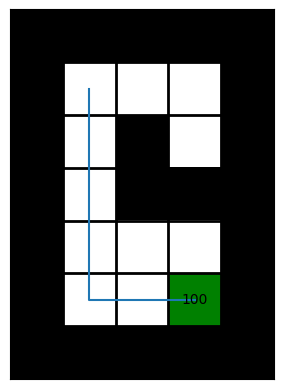

In [ ]:
#Trace the path of the agent based on the predicted max Q-value/action pair using the trained NN
player1 = agent()
while map.checkState(player1.currPos) <=0:
  encoded = np.array(player1.currPos)
  encoded_reshaped = encoded.reshape([1, encoded.shape[0]])
  predicted = model.predict(encoded_reshaped, verbose=0).flatten()
  action = np.argmax(predicted)
  player1.move(actionsList[action])
player1.moveList.append(player1.currPos)

map.plot(player1.moveList)

###**Neural Network Loss Curve**

This section displays the loss curve of training the main neural network model. The graph shows a downward and eventually converging trend, showing convergence in the training process.

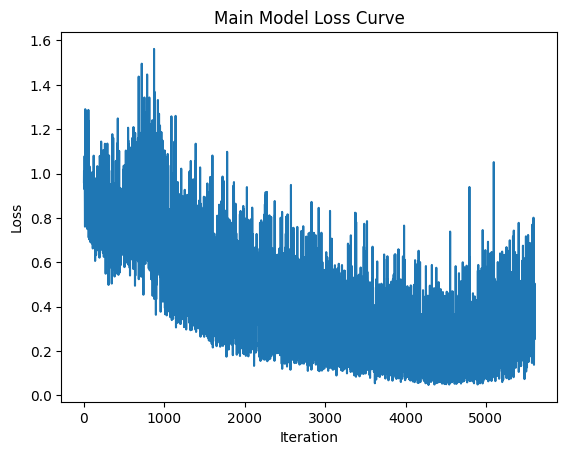

In [ ]:
#Plot the MSE Loss Curve
plt.plot(loss)
plt.title('Main Model Loss Curve')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

###**Rewards Per Episode Graph**

This section displays the graph of total rewards per episode. Although this graph does not show the convergence of the Q-values, it does show that the agent converges to a final optimum path of maximum reward without hitting any obstacles.

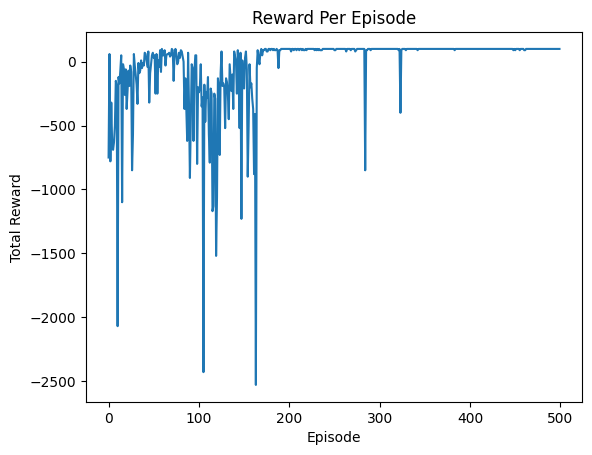

In [ ]:
#Plot the rewards per episode
plt.plot(reward_per_e)
plt.title('Reward Per Episode')
plt.ylabel('Total Reward')
plt.xlabel('Episode')
plt.show()

###**Model Weights Per Iteration**

This section plots the trends in the main model weights as the number of iterations progresses. The graph shows that the weights are trending towards convergence, and that training for more iterations would likely bring them to convergence, but this is currently not realistic due to time and RAM limitations in Google Colab.

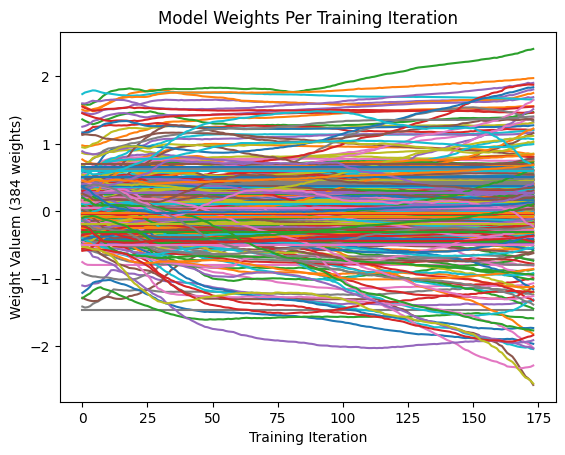

In [ ]:
#Plot the model weights per training iteration
for i in range((2*24 + 24*12 + 12*4)):
  plt.plot(model_weights[i])
plt.title('Model Weights Per Training Iteration')
plt.ylabel('Weight Valuem (384 weights)')
plt.xlabel('Training Iteration')
plt.show()

##Conclusions

This section discusses and analyzes the outcomes of the deep Q-learning training process, focusing on the convergence trends seen in the error, total returns, and neural network weights curves.

###**Deep Q Learning Design, Architecture, and Parameters**
I designed this deep Q-learning problem to utilize two networks, a main network and a target network. Neural networks depend on a target value, which is stationary in most classification/regression problems, to update the weights and train the model on the data. However, in the case of reinforcement learning, the target value is changing continuously with each iteration, making the training unstable. To solve this, I implemented deep Q-learning using a separate main network and target network. The main neural network was used to get the Q value for each action given a current state, and it utilized replay memory. Replay ensures that correlation among samples in a training subset is low, and it increases sample efficiency. The network is trained by splitting the entire replay memory into mini-batches each time it trains, and then making predictions to get the maximum Q-value of the next state using a target network. The target neural network was identical to the first neural network but serves as a lagging copy of the main neural network and only copies over the weights from the main neural network every 100 steps of the agent. This network is used to predict the next states max Q-value, which is then used to calculate the Q-value update using the bellman equation, and the updated Q-value is finally used as the ground-truth with which to train the main network. The weights are only copied over every 100 steps to ensure that there is some stability in the learning process and that the target values are not continuously changing. Regarding the network architecture, I used a simple 4-layer setup with an input layer of size 2 (one node for x coordinate and one for y), two hidden layers of size 24 and 12, and an output layer of size 4 (one for each possible action). Finally, I implemented an epsilon greedy strategy where the initial epsilon was 100% and it decreased to 1% at a decay rate of 1%, favoring high exploration at the beginning. This design and model architecture was used after researching other implementations of deep Q-learning and how to increase efficiency, the articles are shown in the references section.

###**Results Discussion, Convergence, and Graphs**

Overall, the neural network was able to converge to the optimal path to the goal node given enough iterations, resulting in the agent finding the goal node in the optimum number of moves. This is shown by the final agent path trace on the grid world map, as well as the error curve and the total rewards per iteration graph. The error curve shows an overall downward trend which flattens out by the end, indicating that the predicted q-values began to converge. However, there is a lot of noise in the error curve, which is due to the randomness introduced by the epsilon greedy strategy and experience replay. As the number of episodes approaches the limit, the optimal path gets reinforced (due to low epsilon) to the point where its Q-values start to converge, resulting in low error, as seen by the decreasing bottom portion of the error graph. However, there are still many instances of action-value pairs that are in the experience replay buffer with very few visits, which will have a higher error. These instances cause the training process to have spikes of random noise as the neural network attempts to converge the values of states with both few visits and those frequently visited. Overall however, the convergence process is clearly seen by the decreasing and eventually stagnating trend of both the upper spikes and lower portion of the error curve. The convergence process is better seen in the rewards per episode graph. The network starts with a very noisy and negative reward per episode, due to the random action selections from epsilon greedy resulting in the agent hitting obstacles/walls and getting a negative reward. However, as the episodes go by and epsilon decreases, the agent starts to pick the actions given by the neural network prediction a grand majority of the time. Since the graph shows that the line converges to a nearly horizontal line at the optimal reward of 100, this indicates that the neural network has converged to the optimal actions and converges to correctly predicted next actions. Additionally, the weight graphs starts to converge by the last few iterations. This further demonstrates that the neural network has converged the optimal path, but not necessarily all the optimal Q-values. As shown in the error curve and the weight graph, there is still noise and many more episodes could significantly decrease the noise and converge the Q-values as well as the weights. However, this brings us to one of the most important parts of this discussion in the next section, the limitations of efficiency and time with deep Q-learning.


###**Efficiency, Experiments, and Q-Learning Comparison**

Deep Q-learning is generally useful for two main reasons. Firstly, the amount of memory required to save and update that table would greatly increase as the number of states increases. A simple example with 1 thousand states and 1 thousand actions would require 1 million table entries, which is infeasibly memory wise. Secondly, such a grid world or problem would require an unrealistic (and most likely unachievable) amount of time to sufficiently explore each state in order to get the optimal path converged. Thus, deep Q-learning is effective with large state spaces, however, it performs poorly in small state spaces due to the complexity of training a neural network. As shown in this project and through the many experiments with parameters, a 3*5 grid with 3 obstacles took around 30 minutes to converge to the optimal policy, with a larger grid taking serval hours. Clearly, at small grid worlds, a Q-table is much more efficient both time and memory wise, as each run-on Google Colab used up nearly all of the allocated RAM. However, the project did demonstrate how to replace a Q-table with a neural network and that it is feasible to do so, just not practical in small scale projects like this.


###**Final Thoughts**

Overall, this assignment demonstrated the feasibility and power of deep Q-learning for large state spaces. Although the agent path did converge to optimal in this project, many more episodes of training would be required for the Q-values to converge for all states (not just those frequently visited on the optimal path). I maxed out my max RAM many times, and I had to reduce the size of the original grid to a 3*5 in order to finish training to convergence within a reasonable amount of time without maxing out the Google Colab RAM. This process, took many frustrating hours of parameter tuning and testing. However, I learned a lot through this process and it helped me better understand deep reinforcement learning, parameter tuning, and efficiency techniques such as experience replay and epsilon greedy.

##**References**

Inspiration and code snippets for my Deep Q-Learning Network process and architecture based on a cartpole example by Mike Wang:

https://towardsdatascience.com/deep-q-learning-tutorial-mindqn-2a4c855abffc

Other papers and articles used for diagrams and to better understand the Deep Q-learning process.

https://www.nature.com/articles/s42005-021-00684-3

https://www.analyticsvidhya.com/blog/2019/04/introduction-deep-q-learning-python/
